In [1]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
import sys


In [2]:

data = pd.read_csv('../staging/data_set/master_dataset.csv')

In [3]:
data['arr_change'] = data['future_arr'] - data['current_arr']
data['perc_change'] = (data['future_arr'] - data['current_arr']) / data['current_arr']
data['churn_flag'] = (data['future_arr'] < data['current_arr'] * 0.8).astype(int)

In [4]:
data['churn_flag'].value_counts()

churn_flag
0    12769
1      648
Name: count, dtype: int64

Label Encoding

In [5]:
data = pd.get_dummies(data, columns=['crm_industry_current'])
data.columns = data.columns.str.replace(' ', '_')
data.drop(columns=['crm_industry_current'], errors='ignore', inplace=True)



In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['crm_employee_range'] = le.fit_transform(data['crm_employee_range'])


In [7]:
data.shape

(13417, 73)

Feature Grouping

In [8]:
data['seat_utilization_change'] = data['seat_utilization'] - data['seat_utilization_M_before']
data['max_seats_change'] = data['max_seats'] - data['max_seats_M_before']
data["discount_intensity"] = data["discount_arr_usd"] / data["current_arr"].replace(0, np.nan)
data['agent_utilisation_change'] = data['agent_utilization'] - data['agent_utilization_increase']
data['tickets_per_agent'] = data['num_tickets_deflected'] / data['total_pool_max_agents'].replace(0, np.nan)
data["product_change_flag"] = data["product_change_arr"].apply(lambda x: 1 if x > 0 else 0)

Feature Bucketing

In [9]:
def combine_columns(row):
    if row['region_emea'] != 0:
        return 1
    elif row['region_apac'] != 0:
        return 2
    elif row['region_latam'] != 0:
        return 3
    elif row['region_amer'] != 0:
        return 4
    else:
        return 0  

def combine_segment_columns(row):
    if row["segment_smb"] != 0:
        return 1
    elif row["segment_non_smb"] != 0:
        return 2
    elif row["segment_commercial"] != 0:
        return 3
    elif row["segment_enterprise"] != 0:
        return 4
    elif row["segment_midmarket"] != 0:
        return 5
    else:
        return 0


data['regions'] = data.apply(combine_columns, axis=1)

data['segments'] = data.apply(combine_segment_columns, axis=1)

csat_bins = [0, 50, 70, 90, 100]
csat_labels = ["Low (<50)", "Med (50-70)", "High (70-90)", "Very High (90-100)"]
data["csat_bucket"] = pd.cut(
    data["csat_score"], bins=csat_bins, include_lowest=True
)

nps_bins = [-100, -50, -33.3, 0, 9.401423027, 50, 100]
nps_labels = [ "-100 to -50", "-50 to -33.3", "-33.3 to 0", "0 to 9.4", "9.4 to 50", "50 to 100" ]
data["nps_bucket"] = pd.cut(
    data["nps_score"], bins=nps_bins, labels=nps_labels, include_lowest=True
)

print(data)

                  id  score_date  segment_smb  segment_non_smb  \
0      JMAN_10025258  2023-01-06          0.0              1.0   
1      JMAN_10025258  2023-01-13          0.0              1.0   
2      JMAN_10025258  2023-01-20          0.0              1.0   
3      JMAN_10025258  2023-01-27          0.0              1.0   
4      JMAN_10025258  2023-02-03          0.0              1.0   
...              ...         ...          ...              ...   
13412   JMAN_9999715  2023-03-03          0.0              1.0   
13413   JMAN_9999715  2023-03-10          0.0              1.0   
13414   JMAN_9999715  2023-03-17          0.0              1.0   
13415   JMAN_9999715  2023-03-24          0.0              1.0   
13416   JMAN_9999715  2023-03-31          0.0              1.0   

       segment_commercial  segment_enterprise  segment_midmarket  region_emea  \
0                     0.0                 0.0                0.0          0.0   
1                     0.0                 0.0

In [10]:
print(data['csat_bucket'])

0        (-0.001, 50.0]
1        (-0.001, 50.0]
2        (-0.001, 50.0]
3        (-0.001, 50.0]
4        (-0.001, 50.0]
              ...      
13412    (-0.001, 50.0]
13413    (-0.001, 50.0]
13414    (-0.001, 50.0]
13415    (-0.001, 50.0]
13416    (-0.001, 50.0]
Name: csat_bucket, Length: 13417, dtype: category
Categories (4, interval[float64, right]): [(-0.001, 50.0] < (50.0, 70.0] < (70.0, 90.0] < (90.0, 100.0]]


## Feature Correlation with Target Variable

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = data.select_dtypes(include=["number"])

corr_matrix = numeric_df.corr()

churn_corr = corr_matrix["churn_flag"].sort_values(ascending=False)
print("Top correlations with churn_flag:\n")
print(churn_corr)

Top correlations with churn_flag:

churn_flag               1.000000
current_arr              0.148804
sales_assisted           0.120638
pro_plus                 0.102230
max_seats_M_before       0.098518
                           ...   
arr_change              -0.247345
product_change_arr      -0.276774
legacy_flag                   NaN
total_pool_max_agents         NaN
tickets_per_agent             NaN
Name: churn_flag, Length: 62, dtype: float64


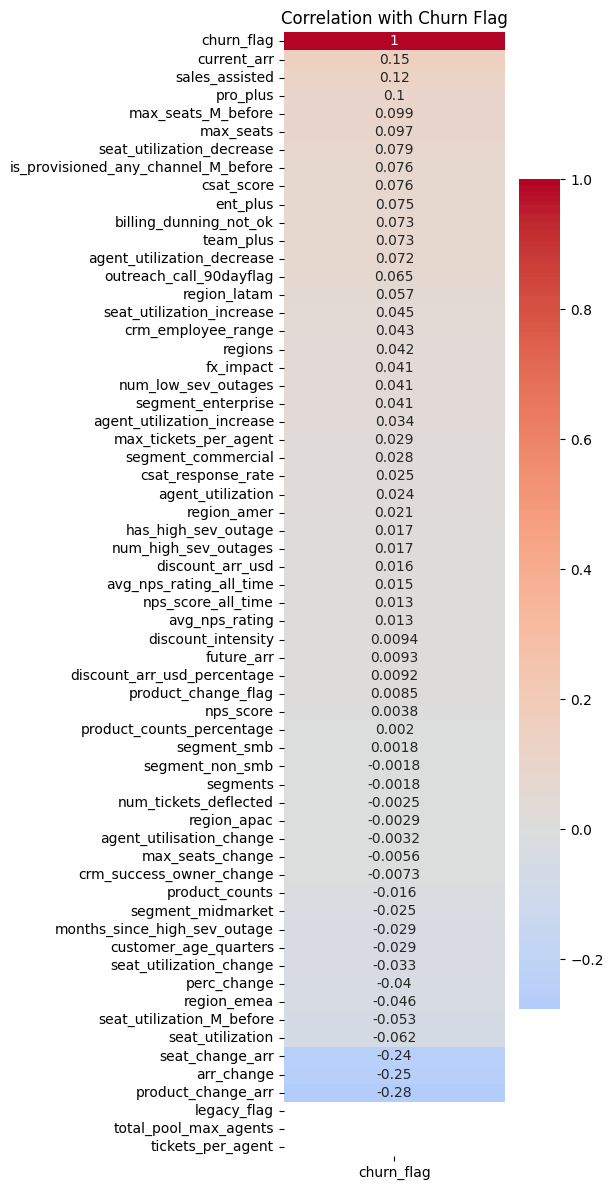

In [12]:
target_corr = corr_matrix[["churn_flag"]].sort_values(by="churn_flag", ascending=False)

plt.figure(figsize=(6, 12))
sns.heatmap(target_corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation with Churn Flag")
plt.tight_layout()
plt.show()

In [13]:
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
import pandas as pd

X = data.drop(columns=["churn_flag"])  
X_numeric = X.select_dtypes(include="number")  

X_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)

X_numeric.fillna(0, inplace=True)

y = data["churn_flag"]

selector = SelectKBest(score_func=f_classif, k=10)  
X_new = selector.fit_transform(X_numeric, y)

selected_columns = X_numeric.columns[selector.get_support()]
print("Top 10 Features (SelectKBest):", selected_columns.tolist())

Top 10 Features (SelectKBest): ['sales_assisted', 'current_arr', 'arr_change', 'seat_change_arr', 'product_change_arr', 'pro_plus', 'max_seats', 'is_provisioned_any_channel_M_before', 'max_seats_M_before', 'seat_utilization_decrease']


c:\Users\puvvu\OneDrive\Documents\web\DS_Miniproject\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [11 28 57] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\puvvu\OneDrive\Documents\web\DS_Miniproject\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


## Recursive Feature Elimination

In [14]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
rfe = RFE(model, n_features_to_select=10)
X_rfe = X_numeric.fillna(0) 
rfe.fit(X_rfe, y)

selected_rfe = X_rfe.columns[rfe.support_]
print("Top 10 Features (RFE):", selected_rfe.tolist())

Top 10 Features (RFE): ['current_arr', 'future_arr', 'arr_change', 'seat_change_arr', 'product_change_arr', 'max_seats', 'is_provisioned_any_channel_M_before', 'max_seats_M_before', 'months_since_high_sev_outage', 'perc_change']


## Over Sampling

In [15]:
import pandas as pd
from imblearn.over_sampling import SMOTE

selected_features = [
    "sales_assisted",
    "pro_plus",
    "seat_utilization_decrease",
    "is_provisioned_any_channel_M_before",
    "csat_score",
    "ent_plus",
    "billing_dunning_not_ok",
    "team_plus",
    "agent_utilization_decrease",
    "outreach_call_90dayflag",
    
    "tickets_per_agent",
    "legacy_flag",
    "perc_change",
    "seat_utilization_change",
    "customer_age_quarters",
    "months_since_high_sev_outage",
    "segment_midmarket",
    "product_counts",
    "crm_industry_current",
    "max_seats_change",
    
    
]

X = X_numeric[selected_features].copy()
y = data["churn_flag"]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_resampled_df = pd.DataFrame(X_resampled, columns=selected_features)

X_resampled_df["churn_flag"] = y_resampled

X_resampled_df.to_csv("churn_features_selected.csv", index=False)

print("File 'churn_features_selected.csv' created with selected features.")

KeyError: "['crm_industry_current'] not in index"

In [ ]:
print(X_resampled.shape, y_resampled.shape)